## 필요 모듈 불러오기

In [46]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [47]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Albumentation 적용

In [48]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

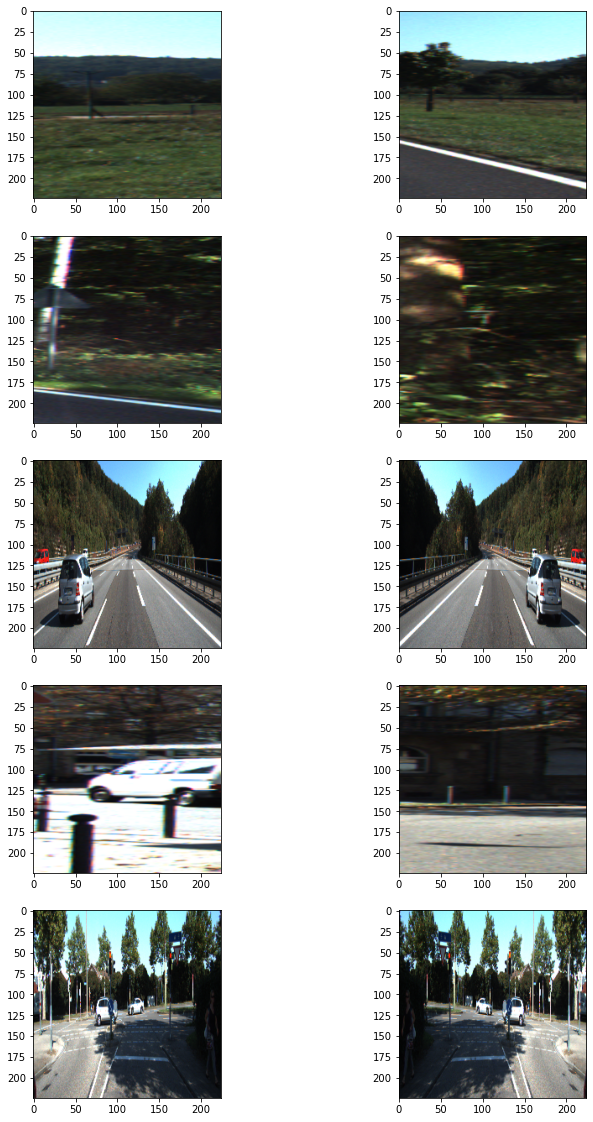

In [49]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

## 데이터셋 구성

In [50]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [51]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 구조 만들기(U-Net)

In [52]:
def build_model(input_shape=(224, 224, 3)):
      inputs = Input(input_shape)

      #Contracting Path
      conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
      conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
      conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
      conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
      conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
      conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
      pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
      conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
      conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
      drop4 = Dropout(0.5)(conv4)
      pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

      conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
      conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

      #Expanding Path
      drop5 = Dropout(0.5)(conv5)
      up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
        Conv2DTranspose(512, 2, strides=(2,2), kernel_initializer='he_normal')(drop5)) 
      merge6 = concatenate([drop4,up6], axis = 3)
      conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
      conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
      up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
        Conv2DTranspose(256, 2, strides=(2,2), kernel_initializer='he_normal')(conv6))
      merge7 = concatenate([conv3,up7], axis = 3)
      conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
      conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
      up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
        Conv2DTranspose(128, 2, strides=(2,2), kernel_initializer='he_normal')(conv7))
      merge8 = concatenate([conv2,up8], axis = 3)
      conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
      conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
      up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
        Conv2DTranspose(64, 2, strides=(2,2), kernel_initializer='he_normal')(conv8))
      merge9 = concatenate([conv1,up9], axis = 3)
      conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
      conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
      conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
      conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

      model = Model(inputs = inputs, outputs = conv10)
      return model

## 모델 학습(U-Net)

In [53]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet22.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 9s 682ms/step - loss: 0.6889 - val_loss: 0.6693
Epoch 2/100
11/11 [==============================] - 7s 612ms/step - loss: 0.6427 - val_loss: 0.1778
Epoch 3/100
11/11 [==============================] - 7s 604ms/step - loss: 0.0816 - val_loss: 0.0356
Epoch 4/100
11/11 [==============================] - 7s 602ms/step - loss: 0.0282 - val_loss: 0.0237
Epoch 5/100
11/11 [==============================] - 7s 604ms/step - loss: 0.0374 - val_loss: 0.0310
Epoch 6/100
11/11 [==============================] - 7s 607ms/step - loss: 0.0286 - val_loss: 0.0318
Epoch 7/100
11/11 [==============================] - 7s 609ms/step - loss: 0.0307 - val_loss: 0.0329
Epoch 8/100
11/11 [==============================] - 7s 616ms/step - loss: 0.0286 - val_loss: 0.0224
Epoch 9/100
11/11 [==============================] - 7s 631ms/step - loss: 0.0287 - val_loss: 0.0241
Epoch 10/100
11/11 [==============================] - 7s 614ms/step - loss: 0.0186 - val_lo

## 모델 시각화(U-Net)

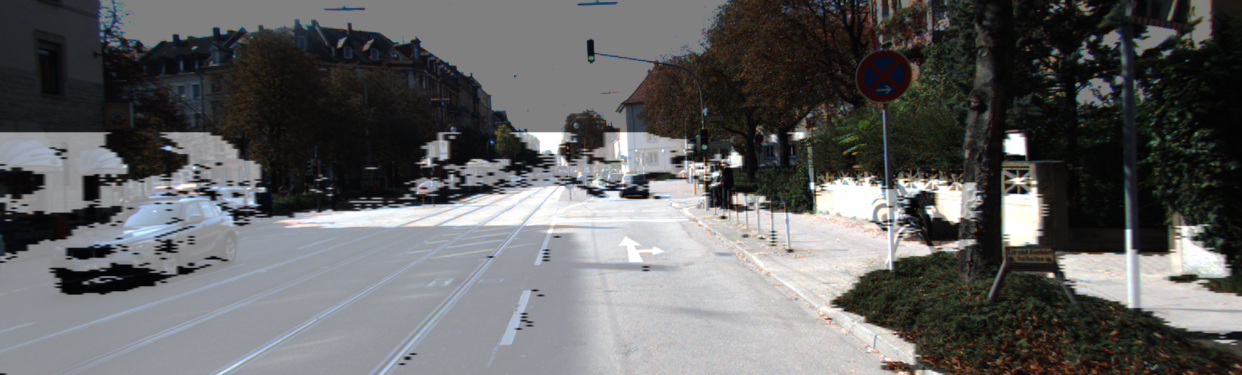

In [61]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
  
  
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## IOU 계산

In [55]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [56]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [60]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.619677


0.6196773079390142

## 모델 구조 만들기(U-Net++)

In [23]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [24]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [25]:
# U-Net++ 모델 구현을 위한 추가 모듈 불러오기
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers import concatenate

In [26]:
def build_model_unetplusplus(input_shape=(224, 224, 3)):
        inputs = Input(input_shape)

        #Contracting Path
        conv1_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        BatchNorm1_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv1_1)
        ReLU1_1 = Activation('relu')(BatchNorm1_1)
        conv1_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU1_1)
        drop1_2 = Dropout(0)(conv1_2)
        Merge1 = concatenate([conv1_1,drop1_2], axis = 3)
        pool1 = MaxPooling2D(pool_size=(2, 2))(Merge1)

        conv2_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        BatchNorm2_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv2_1)
        ReLU2_1 = Activation('relu')(BatchNorm2_1)
        conv2_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU2_1)
        drop2_2 = Dropout(0)(conv2_2)
        Merge2 = concatenate([conv2_1,drop2_2], axis = 3)
        pool2 = MaxPooling2D(pool_size=(2, 2))(Merge2)

        conv3_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        BatchNorm3_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv3_1)
        ReLU3_1 = Activation('relu')(BatchNorm3_1)
        conv3_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU3_1)
        drop3_2 = Dropout(0)(conv3_2)
        Merge3 = concatenate([conv3_1,drop3_2], axis = 3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(Merge3)

        conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        BatchNorm4_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv4_1)
        ReLU4_1 = Activation('relu')(BatchNorm4_1)
        conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU4_1)
        drop4_2 = Dropout(0)(conv4_2)
        Merge4 = concatenate([conv4_1,drop4_2], axis = 3)
        drop4 = Dropout(0.5)(Merge4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5_1 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        BatchNorm5_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv5_1)
        ReLU5_1 = Activation('relu')(BatchNorm5_1)
        conv5_2 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU5_1)
        drop5_2 = Dropout(0)(conv5_2)
        Merge5 = concatenate([conv5_1,drop5_2], axis = 3)
        drop5 = Dropout(0.5)(Merge5)

        #Expanding Path
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        BatchNorm6_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv6_1)
        ReLU6_1 = Activation('relu')(BatchNorm6_1)
        conv6_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU6_1)
        drop6_2 = Dropout(0)(conv6_2)
        Merge6 = concatenate([conv6_1,drop6_2], axis = 3)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge6))
        merge7 = concatenate([Merge3,up7], axis = 3)
        conv7_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        BatchNorm7_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv7_1)
        ReLU7_1 = Activation('relu')(BatchNorm7_1)
        conv7_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU7_1)
        drop7_2 = Dropout(0)(conv7_2)
        Merge7 = concatenate([conv7_1,drop7_2], axis = 3)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge7))
        merge8 = concatenate([Merge2,up8], axis = 3)
        conv8_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        BatchNorm8_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv8_1)
        ReLU8_1 = Activation('relu')(BatchNorm8_1)
        conv8_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU8_1)
        drop8_2 = Dropout(0)(conv8_2)
        Merge8 = concatenate([conv8_1,drop8_2], axis = 3)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge8))
        merge9 = concatenate([Merge1,up9], axis = 3)
        conv9_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        BatchNorm9_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv9_1)
        ReLU9_1 = Activation('relu')(BatchNorm9_1)
        conv9_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU9_1)
        drop9_2 = Dropout(0)(conv9_2)
        Merge9 = concatenate([conv9_1,drop9_2], axis = 3)

        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        model1 = Model(inputs = inputs, outputs = conv10)
        return model1

## 모델 학습

In [27]:
model1 = build_model_unetplusplus()
model1.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model1.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unetplusplus1.h5'
model1.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 14s 586ms/step - loss: 0.9887 - val_loss: 0.9596
Epoch 2/100
22/22 [==============================] - 13s 580ms/step - loss: 0.7870 - val_loss: 0.5399
Epoch 3/100
22/22 [==============================] - 14s 651ms/step - loss: 0.3527 - val_loss: 0.4164
Epoch 4/100
22/22 [==============================] - 15s 681ms/step - loss: 0.3566 - val_loss: 0.4837
Epoch 5/100
22/22 [==============================] - 13s 605ms/step - loss: 0.3291 - val_loss: 0.4280
Epoch 6/100
22/22 [==============================] - 13s 599ms/step - loss: 0.3311 - val_loss: 0.4728
Epoch 7/100
22/22 [==============================] - 13s 600ms/step - loss: 0.3237 - val_loss: 0.5501
Epoch 8/100
22/22 [==============================] - 15s 687ms/step - loss: 0.3252 - val_loss: 0.5206
Epoch 9/100
22/22 [==============================] - 14s 647ms/step - loss: 0.3413 - val_loss: 0.5456
Epoch 10/100
22/22 [==============================] - 15s 697ms/step - loss: 0.318

## 모델 시각화

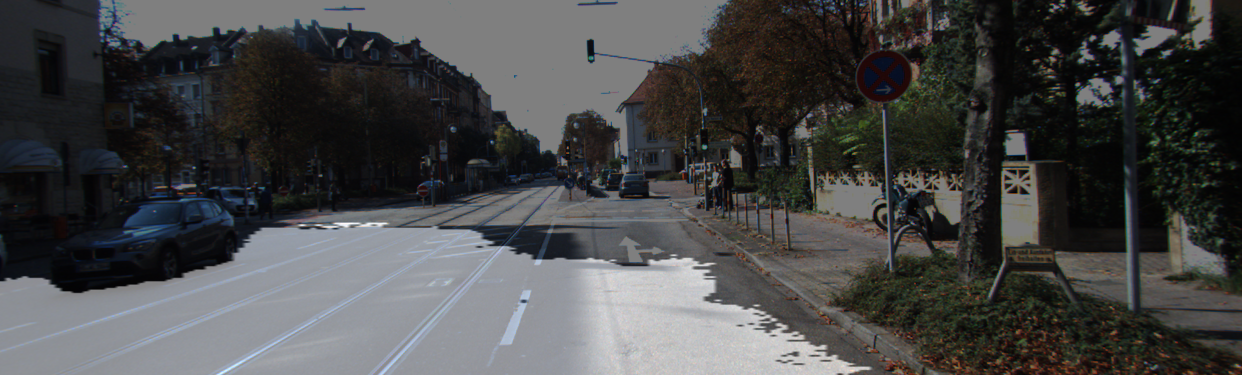

In [68]:
def get_output(model1, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model1(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
  
  
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## IOU 계산

In [69]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [70]:
def get_output(model1, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model1(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [72]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.769436


0.769435736677116